In [1]:
hp1={'alpha': 0.28815202419377745,
 'ccp_alpha': 5.934643617038572,
 'criterion': 0,
 'learning_rate': 0.18713205647733647,
 'loss': 0,
 'max_depth': 6.0,
 'min_impurity_decrease': 12.184228522266157,
 'min_samples_split': 0.2792395135807041,
 'min_weight_fraction_leaf': 0.030673769520341967,
 'n_estimators': 6618.0,
 'subsample': 0.4245813194818062}

In [387]:
hp2={'alpha': 0.16234148344961263,
 'ccp_alpha': 8.419901955112628,
 'criterion': 1,
 'learning_rate': 0.0941839372553873,
 'loss': 0,
 'max_depth': 6.0,
 'min_impurity_decrease': 12.150004214829083,
 'min_samples_split': 0.18518840581261817,
 'min_weight_fraction_leaf': 0.022548950312775547,
 'n_estimators': 4403.0,
 'subsample': 0.4208126529136677}

feat2=['MSSubClass' 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd'
 'MoSold' 'LotFrontage' 'LotArea' 'MasVnrArea' 'BsmtFinSF1' 'BsmtUnfSF'
 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'GrLivArea' 'BsmtFullBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces'
 'GarageYrBlt' 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF'
 'ScreenPorch' 'MSZoning' 'LandContour' 'LotConfig' 'Neighborhood'
 'Condition1' 'BldgType' 'HouseStyle' 'Exterior1st' 'Exterior2nd'
 'ExterQual' 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'
 'HeatingQC' 'CentralAir' 'KitchenQual' 'Functional' 'GarageType'
 'GarageFinish' 'SaleCondition']

# **House Prices Regression Predicction Model**
## **Introduction**
### Dataset Overview
The data model study below is based on Kaggle open dataset: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

This is US Housing dataset in Ames, Lowa. It cotains 79 features related to house information such as SalePrice, LotArea, YearBuilt and quality Condition.

### Objective
The goal is to predict the housing price using historical data and explain what are the key factors afffecting the house price.

### Model Training Flow
1. Data Cleaning & Exploration
2. Data Transformation
3. Model Selection
4. Base Model Training
5. Feature Engineering and Model Finetune
6. Conclusion

## **Import Libaries**
Common libraries for data plotting and model training.
Optuna library is used for model hyperparameter optimization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
rs= RobustScaler()
from sklearn.preprocessing import OrdinalEncoder
oe=OrdinalEncoder()
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()

from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Ridge as RG
from sklearn import linear_model
Lasso = linear_model.Lasso(alpha=0.1)
Lars = linear_model.Lars(n_nonzero_coefs=1)
import xgboost as XGB
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RR

import optuna

#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import cross_validate
#from sklearn import metrics
#from sklearn.model_selection import ShuffleSplit
#from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
#from RegscorePy import *
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score




import shap

#from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")


c:\Users\kongr\Documents\GitHub\env1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#import previous project funtions from kit.py
from kit import *

## **1. Data Cleaning & Exploration**
### **Section Summary:**

### **Section Highlights:**


In [2]:
df_tr=pd.read_csv("train.csv")

Quick check has found 'NaN' in train data

In [3]:
df_tr

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


High level understanding on data. The target response is 'SalePrice'. It has positive skew and high outlier price.

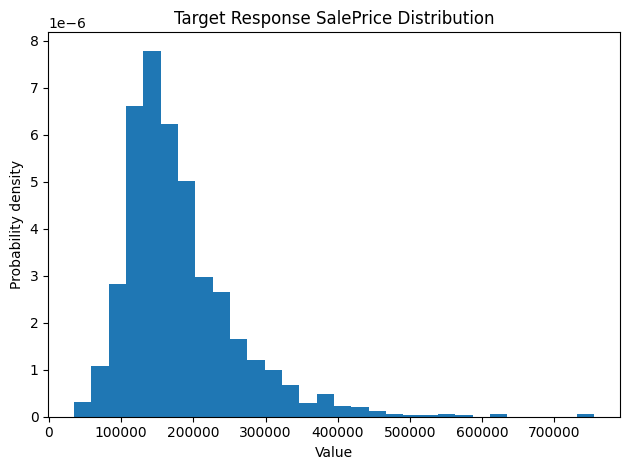

In [4]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(df_tr['SalePrice'], 30, density=True)
ax.set_xlabel('Value')
ax.set_ylabel('Probability density')
ax.set_title('Target Response SalePrice Distribution')
fig.tight_layout()
plt.show()

No duplication.

In [5]:
df_tr.duplicated().sum()

np.int64(0)

At least has two unique values.

In [6]:
df_tr.nunique().sort_values()

Alley            2
Street           2
Utilities        2
CentralAir       2
MasVnrType       3
              ... 
1stFlrSF       753
BsmtUnfSF      780
GrLivArea      861
LotArea       1073
Id            1460
Length: 81, dtype: int64

There are many features having high missing values.

In [7]:
df_tr.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
MasVnrType        872
                 ... 
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice           0
Length: 81, dtype: int64

Create function to investigate the missing values.

In [8]:
def missing_feat(df_tr):
    null_col=pd.DataFrame(columns=['Feature','Total Transaction','Transaction with Missing Value','Missing %'])
    null_col_index=0
    for i in df_tr.isnull().sum().sort_values(ascending=False).index:
        null_col.loc[null_col_index]=[i,
                                    len(df_tr),
                                    df_tr[i].isnull().sum(),
                                    float(df_tr[i].isnull().sum()/len(df_tr))*100,
                                    ]
        null_col_index=null_col_index+1

    print('Top 10 features with highest missing value')
    display(null_col.head(10))

    fig = px.ecdf(null_col, x="Missing %",marginal="histogram",title="Cumulative Distribution of Feature(column) Missing Percentage")

    fig.update_layout(xaxis_title='Missing %',
                        yaxis_title='Accumulated Feature Density',
                        )  

    fig.show()

    return null_col

About 25% features contain missing feature, from ~5% to ~95% missing.

In [9]:
feat_missing_df=missing_feat(df_tr)

Top 10 features with highest missing value


,Feature,Total Transaction,Transaction with Missing Value,Missing %
0,PoolQC,1460,1453,99.520548
1,MiscFeature,1460,1406,96.301370
2,Alley,1460,1369,93.767123
3,Fence,1460,1179,80.753425
4,MasVnrType,1460,872,59.726027
5,FireplaceQu,1460,690,47.260274
6,LotFrontage,1460,259,17.739726
7,GarageQual,1460,81,5.547945
8,GarageFinish,1460,81,5.547945
9,GarageType,1460,81,5.547945


There are features with almost 90% missing values! However the data description file provided by dataset explain certain housing feature are not available, hence it is NaN in the dataset. For example, 'PoolQC' is the quality assessment for the pool:

In [10]:
df_tr['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

There is also feature related to pool area 'PoolArea'. For 'PoolArea' more than 0 (i.e. the house has pool), there are no missing 'PoolQC', in another words, the 'PoolQC' is available only for house with pool. 'Ex' is Excellent, 'Fa' is Fair, etc...

In [11]:
df_tr[['PoolArea','PoolQC']][df_tr['PoolArea']>0]

,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd
1386,519,Fa
1423,738,Gd


Similarly for 'MiscFeature', it is miscellaneous feature which is not covered in other categories. It should be kept as well. 'MiscVa' is the value of the 'MiscFeature'.

In [12]:
df_tr['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [13]:
df_tr[['MiscVal','MiscFeature']][df_tr['MiscVal']>0]

,MiscVal,MiscFeature
5,700,Shed
7,350,Shed
16,700,Shed
17,500,Shed
51,400,Shed
84,700,Shed
95,480,Shed
98,400,Shed
99,400,Shed
106,450,Shed


Similarly,
1. 'Alley': Type of alley access
2. 'Fence': Fence quality
3. 'MasVnrType': Masonry veneer type; 'MasVnrArea': Masonry veneer area in square feet
4. 'FireplaceQu': Fireplace quality; 'Fireplaces': Number of fireplaces
5. 'LotFrontage': Linear feet of street connected to property
6. 'GarageYrBlt': Year garage was built; 'GarageType': Garage location; 'GarageCond': Garage condition

In conclusion, these are valid data and do not have to remove them. Data transformation will be applied on the NaN values before model training.

In [14]:
#Not used
def missing_row(df_tr):
    null_row=pd.DataFrame(columns=['Row ID','Total Feature','Feature With Missing Value','Missing %'])
    null_row_index=0
    for i in range(len(df_tr)):
        if df_tr.iloc[i].isnull().sum()>0:
            null_row.loc[null_row_index]=[df_tr['Id'][i],
                                        len(df_tr.columns),
                                        df_tr.iloc[i].isnull().sum(),
                                        float(df_tr.iloc[i].isnull().sum()/len(df_tr.columns))*100,
            ]
            null_row_index=null_row_index+1

    print('Transaction with missing feature value')
    display(null_row.sort_values(ascending=False,by='Missing %'))

    fig = px.ecdf(null_row, x="Missing %",marginal="histogram",title="Cumulative Distribution of Transaction (row ID) Missing Percentage")

    fig.update_layout(xaxis_title='Missing %',
                        yaxis_title='Accumulated Row Density',
                        )
            
    fig.show()

    return null_row

Moving to data exploration. First thing to find which are numeric and categorical features:

Drop 'Id' and 'SalePrice' befire feature transformation

In [97]:
feat_df=df_tr.drop(['Id','SalePrice'],axis=1)

In [98]:
cat_feat = feat_df.select_dtypes(include=['object', 'bool']).columns
cat_feat.sort_values()

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood',
       'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities'],
      dtype='object')

In [99]:
num_feat = feat_df.select_dtypes(include=['int64', 'float64']).columns
num_feat.sort_values()

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object')

'MSSubClass' is int type but it is supposed to be categorical, hence it is grouped under cat_feat
MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

In [95]:
num_feat=num_feat.drop('MSSubClass')
num_feat

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [96]:
cat_feat=cat_feat.insert(len(cat_feat),'MSSubClass')
cat_feat

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

Create conversion function to convert the quality with ordinary label.
1. Ex	Excellent     ->5
2. Gd	Good   ->4
3.TA	Typical - slight dampness allowed  ->3
4. Fa	Fair - dampness or some cracking or settling     ->2
5. Po	Poor - Severe cracking, settling, or wetness     ->1
6. NA	No Basement   ->0

For numerical feature, quick check on the correlation with the target response 'SalePrice':

In [21]:
#interactive corrrelation heatmap for numberic feat.Roughly check the correlation with target SalePrice, and their intercorrelation
def corr_map(df,included_col,target_response):
    corr_df=df
    for i in corr_df.columns:
        if i not in included_col:
            corr_df=corr_df.drop([i],axis=1)
    
    corr_df=pd.concat([corr_df,df[target_response]],axis=1)

    print('Correlation score with SalePrice:')
    display(corr_df.corr()['SalePrice'].sort_values(ascending=False))
    fig = px.imshow(corr_df.corr(),
                    width=1200,
                    height=800,
                    #text_auto=True,
                    title='Correlation Map'
                    )
    fig.show()
    return corr_df.corr()

'OverallQual', 'GrLivingArea' are the top 2 numerical features with more than +0.7 corretion score

In [22]:
num_feat_corr=corr_map(df_tr,num_feat,'SalePrice')

Correlation score with SalePrice:


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

'OverallCond' is rating of overall material and finishing condition (1 to 10), while 'GrLivArea' is 'above grade (ground) living area square feet'. In scatter plot below, Y axis is the 'SalePrice', X axis is the 'GrLivArea' and the color intensity follow the 'OverallCond'. It is clear that with larger above grade living area and better overall condition, the sale price is higher.

In [23]:
fig = px.scatter(df_tr, x='GrLivArea',y='SalePrice',color='OverallCond')
fig.show()

For categorical features, t-test will be used to see if any abnormal distinction is found.

In [28]:
#t-test feature feat from dataframe
def feat_ttest(df,feat,target_response):
    sig_result=pd.DataFrame(columns=['feat','min one pair feat_val reject h0','feat_val1','feat_val2','p value','statistic','degree of fredom'])
    sig_result_index=0
    for i in feat:
        df1=df[[i,target_response]]
        a=series_dict(df1)
        t_result=series_ttest2(a)
        t_result_min_p_index=t_result.idxmin()[2]
        #print(i,t_result.iloc[t_reult_min_p_index][2])
        if t_result.iloc[t_result_min_p_index][2]<0.05:
            h0_result=True
        if t_result.iloc[t_result_min_p_index][2]>0.05:
            h0_result=False
        sig_result.loc[sig_result_index]=[i,
                                          h0_result,
                                          t_result.iloc[t_result_min_p_index][0],
                                          t_result.iloc[t_result_min_p_index][1],
                                          t_result.iloc[t_result_min_p_index][2],
                                          t_result.iloc[t_result_min_p_index][3],
                                          t_result.iloc[t_result_min_p_index][4],
                                          ]
        sig_result_index=sig_result_index+1
        
    return sig_result.sort_values(by=['p value'])

The t-test function select a pair of subgroups from categorical feature to perform ANOVA test baseed on the target response 'SalePrice'.
The top 5 features only have 2 degrees of fredom, the sample sizes are too small, should not be considered true distinction;

'ExterQual','KitchenQual' and other quality related features have shown the there are distinction between 'TA' (typical or average) and 'Ex' (Excellent). Example is shown below, where 'Ex' has much higher SalePrice than 'TA':

In [29]:
cat_feat_result=feat_ttest(df_tr,cat_feat,'SalePrice')
cat_feat_result.style.format({'p value': '{:.2g}','statistic':'{:.2f}','df':'{:.0f}'})

,feat,min one pair feat_val reject h0,feat_val1,feat_val2,p value,statistic,degree of fredom
15,Exterior1st,True,AsphShn,ImStucc,0,-inf,2.000000
14,RoofMatl,True,Metal,Membran,0,-inf,2.000000
10,Condition2,True,PosA,RRAn,0,inf,2.000000
16,Exterior2nd,True,Other,CBlock,0,inf,2.000000
29,Electrical,True,Mix,nan,0,-inf,2.000000
18,ExterQual,True,TA,Ex,3.5e-153,-31.97,958.000000
30,KitchenQual,True,TA,Ex,4.7e-148,-32.12,835.000000
21,BsmtQual,True,TA,Ex,3.6e-140,-31.43,770.000000
34,GarageFinish,True,Unf,Fin,1.5e-81,-21.12,957.000000
32,FireplaceQu,True,nan,Gd,1.4e-78,-20.43,1070.000000


series_ttest2 function is used to check individual categorical feature t-test result. For example for 'ExterQual', all feat var comparisons are showing very low p values.

In [30]:
#convert feat subgroup into series for t-test
def series_dict(df1):
    a={}
    for i in df1.index:
        if df1.iloc[i][0] not in a:
            a.update({df1.iloc[i][0]:[df1.iloc[i][1]]})
        if df1.iloc[i][0] in a:
            a[df1.iloc[i][0]].append(df1.iloc[i][1])
    return a

#t-test for the feature value from series
def series_ttest2(a):
    i_keys=list(a.keys())
    t_result=pd.DataFrame(columns=['feat_var1','feat_var2','p value','statistic','df'])
    index=0
    for i in range(len(i_keys)):
        if i+1<len(i_keys):
            for k in range(i+1,len(i_keys)):
                t=stats.ttest_ind(a[i_keys[i]],a[i_keys[k]])
                t_result.loc[index]=[str(i_keys[i]),str(i_keys[k]),t.pvalue,t.statistic,t.df]
                index=index+1
    return t_result

In [31]:
a=series_ttest2(series_dict(df_tr[['ExterQual','SalePrice']]))
a.sort_values(by=['p value']).style.format({'p value': '{:.2g}','statistic':'{:.2f}','df':'{:.0f}'})

,feat_var1,feat_var2,p value,statistic,df
3,TA,Ex,3.5e-153,-31.97,958
0,Gd,TA,2.4e-142,28.65,1394
1,Gd,Ex,1.5e-30,-12.24,540
2,Gd,Fa,7.3e-14,7.70,502
5,Ex,Fa,2.5e-13,9.13,66
4,TA,Fa,7.8e-07,4.97,920


viz_response_by_feat_category will plot all the category feature in violin plot. Example for 'ExterCond' (Exterior material quality) is shown below:

![alt text](Assets/ExterQual.png)

viz_response_by_feat_category function will plot the features found reject the h0 hypothesis.

In [32]:
def viz_response_by_feat_category(df,ttest_result,target_response):
    for i in ttest_result['feat']:
        plt.figure(figsize=(10,5))
        sns.violinplot(df,x=i, y=target_response)
        plt.title(f"{i} vs {target_response}")
        plt.xticks(rotation=90)

In [ ]:
viz_response_by_feat_category(df_tr,cat_feat_result,'SalePrice')

Deeper look on individual feature
Inspect feature value normality by normal test and viz

In [39]:
def viz_series_dist(df,feat,target_response):
    df1=df[[feat,target_response]]
    a=series_dict(df1)
    for i in a.keys():
        nor=stats.normaltest(a[i])
        print('feature:',feat,'feat_val:',i,': p value:%.2g statistic:%.2f'%(nor.pvalue,nor.statistic))
        
        fig, ax = plt.subplots()
        n, bins, patches = ax.hist(a[i], 30, density=True)
        ax.set_xlabel('Value')
        ax.set_ylabel('Probability density')
        ax.set_title(f'{feat}_Feature_Value: {i} Distribution')
        fig.tight_layout()
        plt.show()
    

Most of the 'ExterQual' values are normally distributed

feature: ExterQual feat_val: Gd : p value:7.9e-48 statistic:216.92


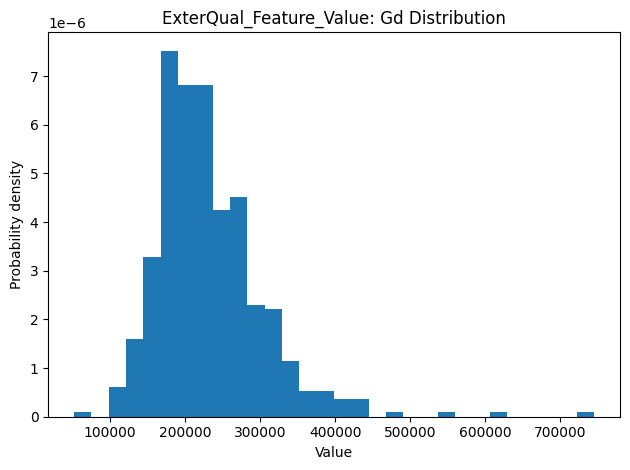

feature: ExterQual feat_val: TA : p value:2.8e-47 statistic:214.35


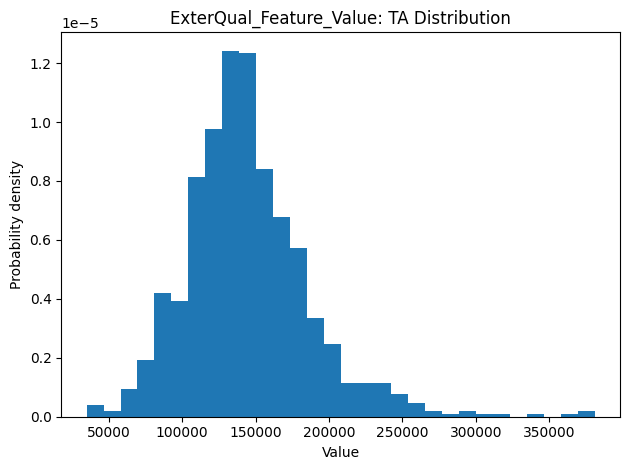

feature: ExterQual feat_val: Ex : p value:0.011 statistic:8.97


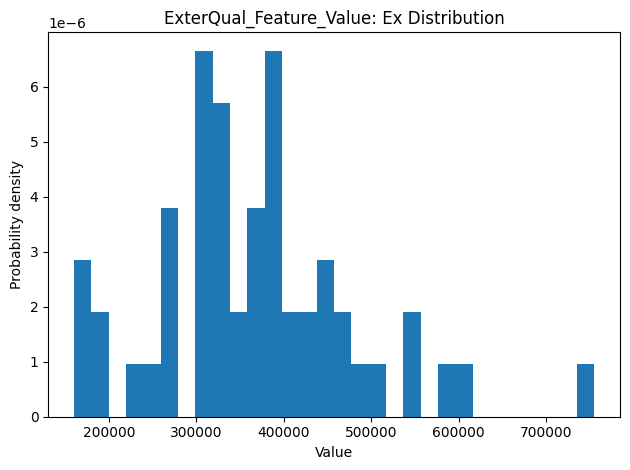

feature: ExterQual feat_val: Fa : p value:0.0018 statistic:12.69


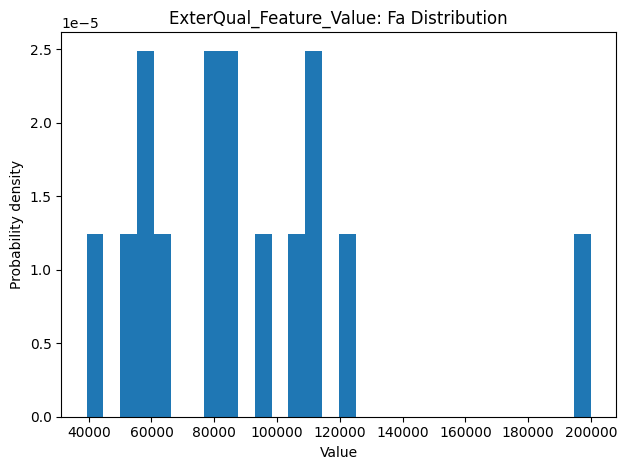

In [40]:
viz_series_dist(df_tr,'ExterQual','SalePrice')

Data transformation

In [ ]:
def conversion1(df,col):
    tr=df.copy()
    for i in col:
        tr=tr.replace(
            {
                np.nan:0,
                'Po':1,
                'Fa':2,
                'TA':3,
                'Gd':4,
                'Ex':5
            }
        )
    return tr

def conversion2(df,col):
    tr=df.copy()
    for i in col:
        tr=tr.replace(
            {
                np.nan:0,
                'No':1,
                'Mn':2,
                'Av':3,
                'Gd':4,
            }
        )
    return tr

def conversion3(df,col):
    tr=df.copy()
    for i in col:
        tr=tr.replace(
            {
                np.nan:0,
                'Unf':1,
                'LwQ':2,
                'Rec':3,
                'BLQ':4,
                'ALQ':5,
                'GLA':6
            }
        )
    return tr

def conversion4(df,col):
    tr=df.copy()
    for i in col:
        tr=tr.replace(
            {
                np.nan:0,
                'MnWw':1,
                'GdWo':2,
                'MnPrv':3,
                'GdPrv':4,
            }
        )
    return tr

def conversion5(df,col):
    tr=tr.replace({np.nan:0})
    return tr

#grouping different feature for understanding and prepare for transformation. Remove ID, hard code ohe encoder and ordinal encoder feat (ord)
#the hard code features are based on the understanding from the given feature description 
binary_feat=['Street',  
             'CentralAir',
             ]

conversion1_feat=['ExterQual',
                 'ExterCond',
                 'BsmtQual',
                 'BsmtCond',
                 'HeatingQC',
                 'KitchenQual',
                 'FireplaceQu',
                 'GarageQual',
                 'GarageCond',
                 'PoolQC',
                 ]

conversion2_feat=['BsmtExposure',
                  ]

conversion3_feat=['BsmtFinType1',
                  'BsmtFinType2'
                  ]

conversion4_feat=['Fence']

conversion5_feat=['MiscFeature']

ord_feat=['OverallQual',
          'OverallCond',
          'ExterQual',
          'ExterCond',
          'KitchenQual',
          'BsmtQual',
          'YearBuilt',
          'YearRemodAdd',
          'MoSold',
          'YrSold',
          'BsmtFullBath',
          'BsmtHalfBath',
          'FullBath',
          'HalfBath',
          'BedroomAbvGr',
          'KitchenAbvGr',
          'TotRmsAbvGrd',
          'Fireplaces',
          'GarageYrBlt',
          ]

for i in ohe_feat:
    feat=feat.drop([i],axis=1)
for i in ord_feat:
    feat=feat.drop([i],axis=1)


In [73]:
def cat_to_rating_conversion(df):
    tr=df.copy()    
    conversion1_feat=['ExterQual',
                 'ExterCond',
                 'BsmtQual',
                 'BsmtCond',
                 'HeatingQC',
                 'KitchenQual',
                 'FireplaceQu',
                 'GarageQual',
                 'GarageCond',
                 'PoolQC',
                 ]
    tr1=tr[conversion1_feat]
    for i in tr1.columns:
        tr1=tr1.replace(
            {
                np.nan:0,
                'Po':1,
                'Fa':2,
                'TA':3,
                'Gd':4,
                'Ex':5
            }
        )

    conversion2_feat=['BsmtExposure',
                  ]
    tr2=tr[conversion2_feat]
    for i in tr2.columns:
        tr2=tr2.replace(
            {
                np.nan:0,
                'No':1,
                'Mn':2,
                'Av':3,
                'Gd':4,
            }
        )

    conversion3_feat=['BsmtFinType1',
                  'BsmtFinType2'
                  ]
    tr3=tr[conversion3_feat]
    for i in tr3.columns:
        tr3=tr3.replace(
            {
                np.nan:0,
                'Unf':1,
                'LwQ':2,
                'Rec':3,
                'BLQ':4,
                'ALQ':5,
                'GLQ':6
            }
        )

    conversion4_feat=['Fence']
    tr4=tr[conversion4_feat]
    for i in tr4.columns:
        tr4=tr4.replace(
            {
                np.nan:0,
                'MnWw':1,
                'GdWo':2,
                'MnPrv':3,
                'GdPrv':4,
            }
        )
    return pd.concat([tr1,tr2,tr3,tr4],axis=1)


In [78]:
rating_df=cat_to_rating_conversion(df_tr)

In [79]:
rating_df

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,BsmtExposure,BsmtFinType1,BsmtFinType2,Fence
0,4,3,4,3,5,4,0,3,3,0,1,6,1,0
1,3,3,4,3,5,3,3,3,3,0,4,5,1,0
2,4,3,4,3,5,4,3,3,3,0,2,6,1,0
3,3,3,3,4,4,4,4,3,3,0,1,5,1,0
4,4,3,4,3,5,4,3,3,3,0,3,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,3,4,3,5,3,3,3,3,0,1,1,1,0
1456,3,3,4,3,3,3,3,3,3,0,1,5,3,3
1457,5,4,3,4,5,4,4,3,3,0,1,6,1,4
1458,3,3,3,3,4,4,0,3,3,0,2,6,3,0


After convert 'Nan' into rating based on the data description, there is no more 'missing value'.

In [80]:
feat_missing_df=missing_feat(rating_df)

Top 10 features with highest missing value


,Feature,Total Transaction,Transaction with Missing Value,Missing %
0,ExterQual,1460,0,0.0
1,ExterCond,1460,0,0.0
2,BsmtQual,1460,0,0.0
3,BsmtCond,1460,0,0.0
4,HeatingQC,1460,0,0.0
5,KitchenQual,1460,0,0.0
6,FireplaceQu,1460,0,0.0
7,GarageQual,1460,0,0.0
8,GarageCond,1460,0,0.0
9,PoolQC,1460,0,0.0


In [102]:
cat_feat

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
       'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive',
       'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

In [103]:
num_feat

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [128]:
len(cat_feat)+len(num_feat)+len(rating_df.columns)

79

In [127]:
len(df_tr.columns)

81

In [104]:
df_tr[num_feat]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,548,0,61,0,0,0,0,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,460,298,0,0,0,0,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,608,0,42,0,0,0,0,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,642,0,35,272,0,0,0,0,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,5,1999,2000,0.0,0,0,953,...,460,0,40,0,0,0,0,0,8,2007
1456,85.0,13175,6,6,1978,1988,119.0,790,163,589,...,500,349,0,0,0,0,0,0,2,2010
1457,66.0,9042,7,9,1941,2006,0.0,275,0,877,...,252,0,60,0,0,0,0,2500,5,2010
1458,68.0,9717,5,6,1950,1996,0.0,49,1029,0,...,240,366,0,112,0,0,0,0,4,2010


In [153]:
def data_transform(df_tr):
    print(f'Original df contains {len(df_tr.columns)} columns;')

    feat_df=df_tr.drop(['Id','SalePrice'],axis=1)
    print(f'After droping Id and SalePrice columns, it has total {len(feat_df.columns)} features;')
    
    rating_df=cat_to_rating_conversion(df_tr)
    print(f'Based on the data description, {len(rating_df.columns)} features are converted from categorical into ordinal features, mostly are rating related;')

    feat_df=feat_df.drop(rating_df.columns,axis=1)
    cat_feat = feat_df.select_dtypes(include=['object', 'bool']).columns
    num_feat = feat_df.select_dtypes(include=['int64', 'float64']).columns
    num_feat=num_feat.drop('MSSubClass')
    cat_feat=cat_feat.insert(len(cat_feat),'MSSubClass')
    print(f'After classify MSSubClass from numerical into categorical feature, the df remains {len(cat_feat)} categorical features and {len(num_feat)} numerical features (other from the ordinal features mentioned above);')


    binary_feat=['Street',  
             'CentralAir',
             ]
    binary_feat_df=df_tr[list(binary_feat)].apply(le.fit_transform)

    ohe_feat=cat_feat.drop(binary_feat)
    ohe_feat_df=pd.DataFrame(ohe.fit_transform(df_tr[list(ohe_feat)]).toarray(),columns=ohe.get_feature_names_out())
    print(f'Among the {len(cat_feat)} catergorical features, {len(binary_feat)} are binary features and are converted using Label Encoder;\n{len(ohe_feat)} categirical features are converted using One-Hot Encoder;')

    num_exception=['YrSold',
                   'MoSold',
                   'YearBuilt',
                   'YearRemodAdd',
                   'OverallQual',
                   'OverallCond',
                   'GarageYrBlt',
                   ]
    
    num_feat_df=pd.DataFrame(rs.fit_transform(df_tr[list(num_feat.drop(num_exception))]),columns=rs.get_feature_names_out())
    print(f'{len(num_exception)} numerical features are related to quality rating and year&month, they are not converted;\nRemaining {len(num_feat_df.columns)} numerical features are converted by Robust Scaler.')

    pro_df=pd.concat([df_tr['SalePrice'],df_tr[num_exception],binary_feat_df,ohe_feat_df,num_feat_df,rating_df],axis=1)
    print(f'Final df contains {len(pro_df.columns.drop('SalePrice'))} features plus SalePrice column, the increased number of features is due to new columns created by One-Hot Encoder')

    return pro_df
    

In [154]:
a=data_transform(df_tr)

Original df contains 81 columns;
After droping Id and SalePrice columns, it has total 79 features;
Based on the data description, 14 features are converted from categorical into ordinal features, mostly are rating related;
After classify MSSubClass from numerical into categorical feature, the df remains 30 categorical features and 35 numerical features (other from the ordinal features mentioned above);
Among the 30 catergorical features, 2 are binary features and are converted using Label Encoder;
28 categirical features are converted using One-Hot Encoder;
7 numerical features are related to quality rating and year&month, they are not converted;
Remaining 28 numerical features are converted by Robust Scaler.
Final df contains 255 features plus SalePrice column, the increased number of features is due to new columns created by One-Hot Encoder


In [155]:
a

,SalePrice,YrSold,MoSold,YearBuilt,YearRemodAdd,OverallQual,OverallCond,GarageYrBlt,Street,CentralAir,...,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,BsmtExposure,BsmtFinType1,BsmtFinType2,Fence
0,208500,2008,2,2003,2003,7,5,2003.0,1,1,...,5,4,0,3,3,0,1,6,1,0
1,181500,2007,5,1976,1976,6,8,1976.0,1,1,...,5,3,3,3,3,0,4,5,1,0
2,223500,2008,9,2001,2002,7,5,2001.0,1,1,...,5,4,3,3,3,0,2,6,1,0
3,140000,2006,2,1915,1970,7,5,1998.0,1,1,...,4,4,4,3,3,0,1,5,1,0
4,250000,2008,12,2000,2000,8,5,2000.0,1,1,...,5,4,3,3,3,0,3,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,2007,8,1999,2000,6,5,1999.0,1,1,...,5,3,3,3,3,0,1,1,1,0
1456,210000,2010,2,1978,1988,6,6,1978.0,1,1,...,3,3,3,3,3,0,1,5,3,3
1457,266500,2010,5,1941,2006,7,9,1941.0,1,1,...,5,4,4,3,3,0,1,6,1,4
1458,142125,2010,4,1950,1996,5,6,1950.0,1,1,...,4,4,0,3,3,0,2,6,3,0


Explore model training

In [ ]:
reg_predictions,reg_result=reg.fit(x_tr,x_val,y_tr,y_val)

In [ ]:
reg_predictions

In [47]:
#visualize the training lazzy regressor result
def viz_reg_result(df):
    df1=df
    for i in range(len(df)):
        if df.iloc[i][0]<0 or df.iloc[i][0]>1:
            df1=df1.drop(df.index[i])
    
    fig = go.Figure(
    go.Bar(
    x=df1.index,
    y=df1['RMSE'],
    name='RMSE'
    )

    )
    for i in df1.columns.drop('RMSE','Time Taken'):
        fig.add_trace(
            go.Line(
            x=df1.index,
            y=df1[i],
            yaxis="y2",
            name=i
            )
        )
    fig.update_layout(
        legend=dict(
            orientation="h",
            entrywidth=500,
            yanchor='bottom',
            y=1.02,
            xanchor='right',
            x=1
            ),
        yaxis=dict(
            title=dict(text='RMSE'),
            side='left',
        ),
        yaxis2=dict(
            title=dict(text='Adj R2 and R2'),
            side='right',
            #range=[0.86,0.93],
            overlaying='y',
            tickmode='sync',
        )
    )
    fig.show()

In [ ]:
viz_reg_result(reg_result)

In [5]:
def data_transform2(df,ohe_feat,ord_feat,num_feat,cat_feat,target_response):
    ohe_feat_df=pd.DataFrame()
    for i in ohe_feat:
        ohe_feat_df=pd.concat([ohe_feat_df,df[i]],axis=1)
    ohe_feat_df=pd.DataFrame(oe.fit_transform(ohe_feat_df),columns=list(ohe_feat))
    pro_ohe_feat=ohe_feat_df.columns

    ord_feat_df=pd.DataFrame()
    for i in ord_feat:
        ord_feat_df=pd.concat([ord_feat_df,df[i]],axis=1)
    ord_feat_df=pd.DataFrame(oe.fit_transform(ord_feat_df),columns=list(ord_feat))
    pro_ord_feat=ord_feat_df.columns

    num_feat_df=pd.DataFrame()
    for i in num_feat:
        num_feat_df=pd.concat([num_feat_df,df[i]],axis=1)
    num_feat_df=pd.DataFrame(rs.fit_transform(num_feat_df),columns=list(num_feat_df))
    pro_num_feat=num_feat_df.columns

    cat_feat_df=pd.DataFrame()
    for i in cat_feat:
        cat_feat_df=pd.concat([cat_feat_df,df[i]],axis=1)
    cat_feat_df=pd.DataFrame(oe.fit_transform(cat_feat_df),columns=list(cat_feat))
    pro_cat_feat=cat_feat_df.columns

    return pd.concat([ohe_feat_df,ord_feat_df,num_feat_df,cat_feat_df,df[target_response]],axis=1)

In [20]:
trans_df_tr2=data_transform2(df_tr,ohe_feat,ord_feat,num_feat,cat_feat,'SalePrice')
trans_df_tr2

,MSSubClass,OverallQual,OverallCond,ExterQual,ExterCond,KitchenQual,BsmtQual,YearBuilt,YearRemodAdd,MoSold,...,Electrical,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,5.00,6.00,4.00,2.00,4.00,2.00,2.00,104.00,53.00,1.00,...,4.00,6.00,1.00,1.00,4.00,4.00,2.00,8.00,4.00,208500
1,0.00,5.00,7.00,3.00,4.00,3.00,2.00,77.00,26.00,4.00,...,4.00,6.00,1.00,1.00,4.00,4.00,2.00,8.00,4.00,181500
2,5.00,6.00,4.00,2.00,4.00,2.00,2.00,102.00,52.00,8.00,...,4.00,6.00,1.00,1.00,4.00,4.00,2.00,8.00,4.00,223500
3,6.00,6.00,4.00,3.00,4.00,2.00,3.00,19.00,20.00,1.00,...,4.00,6.00,5.00,2.00,4.00,4.00,2.00,8.00,0.00,140000
4,5.00,7.00,4.00,2.00,4.00,2.00,2.00,101.00,50.00,11.00,...,4.00,6.00,1.00,1.00,4.00,4.00,2.00,8.00,4.00,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,5.00,5.00,4.00,3.00,4.00,3.00,2.00,100.00,50.00,7.00,...,4.00,6.00,1.00,1.00,4.00,4.00,2.00,8.00,4.00,175000
1456,0.00,5.00,5.00,3.00,4.00,3.00,2.00,79.00,38.00,1.00,...,4.00,2.00,1.00,2.00,4.00,4.00,2.00,8.00,4.00,210000
1457,6.00,6.00,8.00,0.00,2.00,2.00,3.00,44.00,56.00,4.00,...,4.00,6.00,1.00,1.00,4.00,4.00,2.00,8.00,4.00,266500
1458,0.00,4.00,5.00,3.00,4.00,2.00,3.00,51.00,46.00,3.00,...,0.00,6.00,1.00,2.00,4.00,4.00,2.00,8.00,4.00,142125


In [21]:
#create tst data set (unseen data)
x2=trans_df_tr2.drop('SalePrice',axis=1)
y2=trans_df_tr2['SalePrice']
x2_tr,x2_tst,y2_tr,y2_tst=train_test_split(x2,y2,train_size=0.9,shuffle=True)
#train val set for training
x2_tr,x2_val,y2_tr,y2_val=train_test_split(x2_tr,y2_tr,train_size=0.8,shuffle=True)

In [22]:
y2_tst.describe()

count      146.00
mean    176022.77
std      75225.88
min      35311.00
25%     127750.00
50%     159500.00
75%     204000.00
max     430000.00
Name: SalePrice, dtype: float64

In [51]:
reg_predictions2,reg_result2=reg.fit(x2_tr,x2_val,y2_tr,y2_val)

100%|██████████| 42/42 [00:04<00:00,  9.49it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3041
[LightGBM] [Info] Number of data points in the train set: 1051, number of used features: 67
[LightGBM] [Info] Start training from score 180412.350143


In [52]:
reg_result2

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.89,0.92,23599.13,0.31
RandomForestRegressor,0.87,0.90,25452.84,0.89
ExtraTreesRegressor,0.86,0.90,26341.72,0.66
HistGradientBoostingRegressor,0.84,0.89,27748.06,0.17
XGBRegressor,0.84,0.88,28002.40,0.12
LGBMRegressor,0.83,0.88,28680.17,0.11
HuberRegressor,0.82,0.87,29400.25,0.05
BaggingRegressor,0.82,0.87,29781.74,0.10
PassiveAggressiveRegressor,0.82,0.87,30092.82,0.04


In [53]:
viz_reg_result(reg_result2)

h:\Other computers\My Computer\Work\bank_term_deposit_v3\env3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




GradientBoostingRegressor

In [54]:
def remove_null(df):
    x_df=df
    c_col=df.select_dtypes(include=['object', 'bool']).columns
    n_col=df.select_dtypes(include=['int64', 'float64']).columns
    for i in c_col:
        x_df[i]=x_df[i].fillna('')
    for i in n_col:
        x_df[i]=x_df[i].fillna(0)    
    return x_df

In [55]:
x2_tr=remove_null(x2_tr)
x2_val=remove_null(x2_val)
x2_tst=remove_null(x2_tst)

In [56]:
def reg_result(model,val_x,val_y):
    pred_=model.predict(val_x)
    rmse_=root_mean_squared_error(val_y,pred_)
    r2_=r2_score(val_y,pred_)
    adj_r2_=1-(1-r2_)*(len(val_x)-1)/(len(val_x)-model.n_features_in_-1)
    print(f'RMSE:${round(rmse_):,} R2:%.4f Adj R2:%.4f'%(r2_,adj_r2_))

In [57]:
gbr_loss=['squared_error','absolute_error','huber','quantile']
gbr_criterion=['friedman_mse', 'squared_error']
gbr_space={
 'alpha': hp.uniform ('alpha',0,1),
 'ccp_alpha': hp.uniform ('ccp_alpha',0,100),
 'criterion': hp.choice('criterion',gbr_criterion),
 'init': None,
 'learning_rate': hp.uniform ('learning_rate',0,1),
 'loss': hp.choice('loss',gbr_loss),
 'max_depth': hp.quniform ('max_depth', 1,20,1),
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': hp.uniform ('min_impurity_decrease', 0.01,100),
 'min_samples_leaf': 1,
 'min_samples_split': hp.uniform ('min_samples_split', 0.01,1),
 'min_weight_fraction_leaf': hp.uniform ('min_weight_fraction_leaf', 0.,0.5),
 'n_estimators': hp.quniform ('n_estimators', 1000,5000,500),
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': hp.uniform ('subsample', 0.01,0.5),
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False,
 'x_tr':x2_tr,
 'x_val':x2_val,
 'y_tr':y2_tr,
 'y_val':y2_val,
 'pro_df_tr':trans_df_tr2,
 'target_response':'SalePrice'
 }

In [60]:
def objective_cv(space):

    hp_reg=GradientBoostingRegressor(
        alpha=space['alpha'],
        ccp_alpha=space['ccp_alpha'],
        criterion=space['criterion'],
        init=space['init'],
        learning_rate=space['learning_rate'],
        loss=space['loss'],
        max_depth=int(space['max_depth']),
        max_features=space['max_features'],
        max_leaf_nodes=space['max_leaf_nodes'],
        min_impurity_decrease=space['min_impurity_decrease'],
        min_samples_leaf=space['min_samples_leaf'],
        min_samples_split=space['min_samples_split'],
        min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        n_estimators=int(space['n_estimators']),
        n_iter_no_change=space['n_iter_no_change'],
        random_state=space['random_state'],
        subsample=space['subsample'],
        tol=space['tol'],
        validation_fraction=space['validation_fraction'],
        verbose=space['verbose'],
        warm_start=space['warm_start'],
    )

    pro_df=remove_null(space['pro_df_tr'])
    df1,k1=train_test_split(pro_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)

    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]
    for i in range(len(a)):
        b=a.copy()
        #assign validation set
        x_val1=b[i].drop(space['target_response'],axis=1)
        y_val1=b[i][space['target_response']]
        #assing training set
        del b[i]
        tr=pd.DataFrame()
        for j in range(len(b)):
            tr=pd.concat([tr,b[j]],axis=0)
        x_tr1=tr.drop(space['target_response'],axis=1)
        y_tr1=tr[space['target_response']]

        hp_reg.fit(x_tr1,
                    y_tr1,
                    )
           
        pred_=hp_reg.predict(x_val1)
        rmse_=root_mean_squared_error(y_val1,pred_)
        r2_=r2_score(y_val1,pred_)
        adj_r2_=1-(1-r2_)*(len(x_val1)-1)/(len(x_val1)-hp_reg.n_features_in_-1)
        #cv_score[i]=rmse_/(r2_*adj_r2_)
        cv_score[i]=rmse_
        print(f'RMSE:${round(rmse_):,} R2:%.4f Adj R2:%.4f'%(r2_,adj_r2_))
    #best_score=sum(cv_score)/len(cv_score)
    best_score=max(cv_score)
    
    print(f"The score from this cv is {round(best_score):,}")

    return {'loss': best_score, 'status': STATUS_OK }

In [65]:
def hyperopt_hp_cv(objective, space):
    trials = Trials()

    best_hyperparams = fmin(fn = objective,
                            space = space,
                            algo = tpe.suggest,
                            max_evals = 100,
                            trials = trials,
                            )
    return best_hyperparams

In [66]:
hpdict=hyperopt_hp_cv(objective_cv, gbr_space)

RMSE:$84,227 R2:-0.0322 Adj R2:-0.3778                 
RMSE:$75,692 R2:-0.0092 Adj R2:-0.3471                 
RMSE:$76,507 R2:-0.0176 Adj R2:-0.3584                 
RMSE:$74,697 R2:-0.0044 Adj R2:-0.3407                 
RMSE:$87,822 R2:-0.0058 Adj R2:-0.3426                 
The score from this cv is 87,822                       
RMSE:$88,705 R2:-0.0010 Adj R2:-0.3362                                          
RMSE:$81,376 R2:-0.0030 Adj R2:-0.3388                                          
RMSE:$65,603 R2:-0.0005 Adj R2:-0.3355                                          
RMSE:$77,005 R2:-0.0148 Adj R2:-0.3546                                          
RMSE:$82,829 R2:-0.0001 Adj R2:-0.3350                                          
The score from this cv is 88,705                                                
RMSE:$28,937 R2:0.8548 Adj R2:0.8062                                            
RMSE:$29,908 R2:0.8364 Adj R2:0.7816                                            
RMSE:$37,182 R2:

In [69]:
#Fit model with parameter dict and space
def fit_para(space,hpdict0):

    model=GradientBoostingRegressor(
        alpha=0.9,
        ccp_alpha=hpdict0['ccp_alpha'],
        criterion=gbr_criterion[hpdict0['criterion']],
        init=space['init'],
        learning_rate=hpdict0['learning_rate'],
        loss=gbr_loss[hpdict0['loss']],
        max_depth=int(hpdict0['max_depth']),
        max_features=space['max_features'],
        max_leaf_nodes=space['max_leaf_nodes'],
        min_impurity_decrease=hpdict0['min_impurity_decrease'],
        min_samples_leaf=space['min_samples_leaf'],
        min_samples_split=hpdict0['min_samples_split'],
        min_weight_fraction_leaf=hpdict0['min_weight_fraction_leaf'],
        n_estimators=int(hpdict0['n_estimators']),
        n_iter_no_change=space['n_iter_no_change'],
        random_state=space['random_state'],
        subsample=hpdict0['subsample'],
        tol=space['tol'],
        validation_fraction=space['validation_fraction'],
        verbose=space['verbose'],
        warm_start=space['warm_start'],
    )

    return model

In [73]:
hp_gbr_model=fit_para(gbr_space,hpdict)
hp_gbr_model.fit(x2_tr,y2_tr)
print('\nfeat number:',hp_gbr_model.n_features_in_,'\n features used:',hp_gbr_model.feature_names_in_)


feat number: 73 
 features used: ['MSSubClass' 'OverallQual' 'OverallCond' 'ExterQual' 'ExterCond'
 'KitchenQual' 'BsmtQual' 'YearBuilt' 'YearRemodAdd' 'MoSold' 'YrSold'
 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr'
 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt' 'LotFrontage'
 'LotArea' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MSZoning' 'Street'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'Foundation'
 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'Heating'
 'HeatingQC' 'CentralAir' 'Electrical' 'Functional' 'GarageType'
 'GarageFinish' 'GarageQual' 'GarageCond' 'PavedDrive' 'SaleType'
 'SaleCondition']


In [74]:
reg_result(hp_gbr_model,x2_tr,y2_tr)

RMSE:$11,536 R2:0.9782 Adj R2:0.9766


In [75]:
reg_result(hp_gbr_model,x2_val,y2_val)

RMSE:$29,409 R2:0.8728 Adj R2:0.8237


In [76]:
reg_result(hp_gbr_model,x2_tst,y2_tst)

RMSE:$28,868 R2:0.8771 Adj R2:0.7525


In [77]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    
    imp_percent_col=pd.DataFrame(columns=['percentage'])
    for i in range(len(feature_importance)):
        imp_percent_col.loc[i]=[feature_importance['importance'][i]/sum(feature_importance['importance'])]
    
    feature_importance=pd.concat([feature_importance,imp_percent_col],axis=1)

    return feature_importance.sort_values(by=['importance'],ascending=False).reset_index(drop=True),shap_values

In [82]:
feat_imp,shap_values=global_shap_importance(hp_gbr_model,x2_tr)
feat_imp

,features,importance,percentage
0,OverallQual,13829.58,0.12
1,GrLivArea,12636.34,0.11
2,YearBuilt,6643.15,0.06
3,TotalBsmtSF,6559.04,0.06
4,BsmtFinSF1,6030.64,0.05
...,...,...,...
68,Street,0.00,0.00
69,MiscVal,0.00,0.00
70,PoolArea,0.00,0.00
71,LowQualFinSF,0.00,0.00


In [79]:
fig = go.Figure(
    go.Bar(
    x=feat_imp['features'],
    y=feat_imp['percentage'],
    name='SHAP Importance'
    )
    )
fig.update_layout(
    yaxis=dict(
        title=dict(text='SHAP Importance'),
    ),
)
fig.show()

In [83]:
def drop_feat(x,imp,threshold):
    df=x
    for i in range(len(imp)):
        if float(imp.loc[i][2])<threshold:
            df=df.drop([imp.loc[i][0]],axis=1)
    return df

In [84]:
x3_tr=drop_feat(x2_tr,feat_imp,0.005)
x3_val=drop_feat(x2_val,feat_imp,0.005)
x3_tst=drop_feat(x2_tst,feat_imp,0.005)

In [86]:
hp_gbr_model=fit_para(gbr_space,hpdict)
hp_gbr_model.fit(x3_tr,y2_tr)
print('\nfeat number:',hp_gbr_model.n_features_in_,'\n features used:',hp_gbr_model.feature_names_in_)


feat number: 43 
 features used: ['MSSubClass' 'OverallQual' 'OverallCond' 'ExterQual' 'KitchenQual'
 'BsmtQual' 'YearBuilt' 'YearRemodAdd' 'MoSold' 'BsmtFullBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces'
 'GarageYrBlt' 'LotFrontage' 'LotArea' 'MasVnrArea' 'BsmtFinSF1'
 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'GrLivArea'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'ScreenPorch'
 'MSZoning' 'LotConfig' 'Neighborhood' 'Condition1' 'HouseStyle'
 'Exterior1st' 'Exterior2nd' 'BsmtFinType1' 'Functional' 'GarageFinish'
 'SaleCondition']


In [87]:
reg_result(hp_gbr_model,x3_tr,y2_tr)

RMSE:$11,595 R2:0.9780 Adj R2:0.9771


In [88]:
reg_result(hp_gbr_model,x3_val,y2_val)

RMSE:$29,512 R2:0.8719 Adj R2:0.8468


In [89]:
reg_result(hp_gbr_model,x3_tst,y2_tst)

RMSE:$28,514 R2:0.8801 Adj R2:0.8296


In [90]:
explainer = shap.TreeExplainer(hp_gbr_model, x2_tr)

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.summary_plot(shap_values, x2_tr)

In [94]:
def hpdict_opt(objective,hpdict0):
    gbr_loss=['squared_error','absolute_error','huber','quantile']
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_space2={
    'alpha': hp.uniform ('alpha',max(0,hpdict0['alpha']-hpdict0['alpha']/2),min(hpdict0['alpha']+hpdict0['alpha']/2,1)),
    'ccp_alpha': hp.uniform ('ccp_alpha',max(0,hpdict0['ccp_alpha']-hpdict0['ccp_alpha']/2),min(hpdict0['ccp_alpha']+hpdict0['ccp_alpha']/2,100)),
    'criterion': hp.choice('criterion',gbr_criterion),
    'init': None,
    'learning_rate': hp.uniform ('learning_rate',max(0,hpdict0['learning_rate']-hpdict0['learning_rate']/2),min(hpdict0['learning_rate']+hpdict0['learning_rate']/2,1)),
    'loss': hp.choice('loss',gbr_loss),
    'max_depth': hp.quniform ('max_depth', max(0,hpdict0['max_depth']-hpdict0['max_depth']/2),min(hpdict0['max_depth']+hpdict0['max_depth']/2,20),1),
    'max_features': None,
    'max_leaf_nodes': None,
    'min_impurity_decrease': hp.uniform ('min_impurity_decrease', max(0,hpdict0['min_impurity_decrease']-hpdict0['min_impurity_decrease']/2),min(hpdict0['min_impurity_decrease']+hpdict0['min_impurity_decrease']/2,50)),
    'min_samples_leaf': 1,
    'min_samples_split': hp.uniform ('min_samples_split', max(0,hpdict0['min_samples_split']-hpdict0['min_samples_split']/2),min(hpdict0['min_samples_split']+hpdict0['min_samples_split']/2,1)),
    'min_weight_fraction_leaf': hp.uniform ('min_weight_fraction_leaf', max(0,hpdict0['min_weight_fraction_leaf']-hpdict0['min_weight_fraction_leaf']/2),min(hpdict0['min_weight_fraction_leaf']+hpdict0['min_weight_fraction_leaf']/2,0.5)),
    'n_estimators': hp.quniform ('n_estimators', max(0,hpdict0['n_estimators']-hpdict0['n_estimators']/2),min(hpdict0['n_estimators']+hpdict0['n_estimators']/2,10000),1),
    'n_iter_no_change': None,
    'random_state': None,
    'subsample': hp.uniform ('subsample', max(0,hpdict0['subsample']-hpdict0['subsample']/2),min(hpdict0['subsample']+hpdict0['subsample']/2,1)),
    'tol': 0.0001,
    'validation_fraction': 0.1,
    'verbose': 0,
    'warm_start': False,
    'x_tr':x3_tr,
    'x_val':x3_val,
    'y_tr':y2_tr,
    'y_val':y2_val,
    'pro_df_tr':trans_df_tr2,
    'target_response':'SalePrice'
    }
    opt_para=hyperopt_hp_cv(objective,gbr_space2)
    return opt_para

In [96]:
hpdict1=hpdict_opt(objective_cv,hpdict)

RMSE:$27,666 R2:0.8625 Adj R2:0.8164                   
RMSE:$35,837 R2:0.7976 Adj R2:0.7298                   
RMSE:$32,277 R2:0.8250 Adj R2:0.7664                   
RMSE:$51,497 R2:0.7002 Adj R2:0.5997                   
RMSE:$24,111 R2:0.8777 Adj R2:0.8368                   
The score from this cv is 51,497                       
RMSE:$179,541 R2:-2.5926 Adj R2:-3.7956                                         
RMSE:$163,176 R2:-3.3587 Adj R2:-4.8182                                         
RMSE:$155,400 R2:-4.4225 Adj R2:-6.2383                                         
RMSE:$158,424 R2:-3.1063 Adj R2:-4.4814                                         
RMSE:$159,958 R2:-3.4095 Adj R2:-4.8860                                         
The score from this cv is 179,541                                               
RMSE:$31,149 R2:0.8045 Adj R2:0.7390                                            
RMSE:$36,019 R2:0.7652 Adj R2:0.6866                                            
RMSE:$34,802 R2:

In [97]:
hpdict1

{'alpha': 1.2585688032700096e-05,
 'ccp_alpha': 41.63808338408212,
 'criterion': 1,
 'learning_rate': 0.21124025532897286,
 'loss': 0,
 'max_depth': 2.0,
 'min_impurity_decrease': 39.83909504584152,
 'min_samples_split': 0.16824141830502523,
 'min_weight_fraction_leaf': 0.04728817054820532,
 'n_estimators': 1161.0,
 'subsample': 0.33829276356150506}

In [98]:
hp_gbr_model=fit_para(gbr_space,hpdict1)
hp_gbr_model.fit(x3_tr,y2_tr)
print('\nfeat number:',hp_gbr_model.n_features_in_,'\n features used:',hp_gbr_model.feature_names_in_)


feat number: 43 
 features used: ['MSSubClass' 'OverallQual' 'OverallCond' 'ExterQual' 'KitchenQual'
 'BsmtQual' 'YearBuilt' 'YearRemodAdd' 'MoSold' 'BsmtFullBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces'
 'GarageYrBlt' 'LotFrontage' 'LotArea' 'MasVnrArea' 'BsmtFinSF1'
 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'GrLivArea'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'ScreenPorch'
 'MSZoning' 'LotConfig' 'Neighborhood' 'Condition1' 'HouseStyle'
 'Exterior1st' 'Exterior2nd' 'BsmtFinType1' 'Functional' 'GarageFinish'
 'SaleCondition']


In [99]:
reg_result(hp_gbr_model,x3_tr,y2_tr)

RMSE:$11,443 R2:0.9786 Adj R2:0.9777


In [100]:
reg_result(hp_gbr_model,x3_val,y2_val)

RMSE:$27,607 R2:0.8879 Adj R2:0.8659


In [101]:
reg_result(hp_gbr_model,x3_tst,y2_tst)

RMSE:$30,399 R2:0.8637 Adj R2:0.8063


In [102]:
feat_imp,shap_values=global_shap_importance(hp_gbr_model,x3_tr)

In [103]:
fig = go.Figure(
    go.Bar(
    x=feat_imp['features'],
    y=feat_imp['percentage'],
    name='SHAP Importance'
    )
    )
fig.update_layout(
    yaxis=dict(
        title=dict(text='SHAP Importance'),
    ),
)
fig.show()

In [ ]:
shap.plots.waterfall(shap_values[0])

In [339]:
x4=x3_tr.drop([feat_imp.loc[len(feat_imp)-(0+1)][0]],axis=1)

In [346]:
def feat_selection(tr_x,tr_y,val_x,val_y,imp,model):
    model.fit(tr_x,tr_y)
    pred_=model.predict(val_x)
    r2_=r2_score(val_y,pred_)
    adj_r2_1=1-(1-r2_)*(len(val_x)-1)/(len(val_x)-model.n_features_in_-1)

    x2=tr_x
    x3=val_x

    for i in range(len(imp)):
        x2=x2.drop([imp.loc[len(imp)-(i+1)][0]],axis=1)
        x3=x3.drop([imp.loc[len(imp)-(i+1)][0]],axis=1)
        model.fit(x2,tr_y)
        pred_=model.predict(x3)
        r2_=r2_score(val_y,pred_)
        adj_r2_2=1-(1-r2_)*(len(x3)-1)/(len(x3)-model.n_features_in_-1)

        if adj_r2_2>=adj_r2_1:
            adj_r2_1=adj_r2_2
        if adj_r2_2<adj_r2_1:
            x2=pd.concat([x2,tr_x[imp.loc[len(imp)-(i+1)][0]]],axis=1)
            x3=pd.concat([x3,val_x[imp.loc[len(imp)-(i+1)][0]]],axis=1)
    print(adj_r2_1)
    print(x2.columns)
    return x2

In [347]:
x4_tr=feat_selection(x3_tr,y2_tr,x3_val,y2_val,feat_imp,hp_gbr_model)

0.8385252836924881
Index(['HouseStyle', 'BldgType', 'Exterior2nd', 'LandContour', 'CentralAir',
       'HeatingQC', 'GarageType', 'ScreenPorch', 'KitchenQual', 'Functional',
       'MoSold', 'FullBath', 'KitchenAbvGr', 'ExterQual', 'Condition1',
       'MasVnrArea', 'GarageFinish', 'BsmtQual', 'BsmtExposure', 'Exterior1st',
       'MSZoning', 'WoodDeckSF', 'SaleCondition', 'TotRmsAbvGrd',
       'LotFrontage', 'BsmtUnfSF', 'BsmtFinType1', 'OpenPorchSF',
       'YearRemodAdd', 'HalfBath', 'GarageYrBlt', 'Fireplaces', 'GarageCars',
       '2ndFlrSF', '1stFlrSF', 'Neighborhood', 'GarageArea', 'OverallCond',
       'LotArea', 'TotalBsmtSF', 'BsmtFinSF1', 'YearBuilt', 'GrLivArea',
       'OverallQual'],
      dtype='object')


In [348]:
x4_tr

,HouseStyle,BldgType,Exterior2nd,LandContour,CentralAir,HeatingQC,GarageType,ScreenPorch,KitchenQual,Functional,...,1stFlrSF,Neighborhood,GarageArea,OverallCond,LotArea,TotalBsmtSF,BsmtFinSF1,YearBuilt,GrLivArea,OverallQual
413,2.00,0.00,15.00,3.00,1.00,2.00,5.00,0.00,3.00,6.00,...,-0.12,17.00,-0.50,5.00,-0.13,0.03,-0.54,31.00,-0.67,4.00
1170,7.00,0.00,10.00,3.00,1.00,4.00,1.00,0.00,3.00,6.00,...,0.06,11.00,-0.51,5.00,0.10,0.21,0.19,78.00,-0.53,5.00
899,2.00,0.00,10.00,3.00,1.00,4.00,1.00,0.00,3.00,6.00,...,0.29,19.00,-0.80,6.00,-0.61,-0.16,0.11,62.00,-0.35,4.00
547,6.00,0.00,13.00,3.00,1.00,0.00,5.00,0.00,3.00,6.00,...,-0.63,11.00,0.60,6.00,-0.55,-0.44,0.33,71.00,-1.08,4.00
273,2.00,0.00,14.00,3.00,1.00,2.00,1.00,0.00,3.00,2.00,...,1.07,12.00,-0.59,5.00,0.03,0.49,0.33,59.00,0.26,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,5.00,0.00,13.00,3.00,1.00,2.00,1.00,0.00,2.00,6.00,...,0.75,15.00,0.89,4.00,-0.07,0.95,0.85,99.00,1.80,7.00
606,2.00,0.00,13.00,2.00,1.00,2.00,5.00,0.00,2.00,6.00,...,-0.09,5.00,0.40,4.00,0.74,0.10,0.49,97.00,-0.66,4.00
40,2.00,0.00,14.00,3.00,1.00,0.00,1.00,0.00,3.00,6.00,...,0.47,12.00,-0.17,4.00,-0.20,0.19,0.36,66.00,-0.22,5.00
32,2.00,0.00,13.00,3.00,1.00,0.00,1.00,0.00,2.00,6.00,...,0.29,5.00,0.02,4.00,0.39,0.48,-0.54,108.00,-0.36,7.00


In [380]:
threshold=0.001
x4_tr=drop_feat(x3_tr,feat_imp,threshold)
x4_val=drop_feat(x3_val,feat_imp,threshold)
x4_tst=drop_feat(x3_tst,feat_imp,threshold)

In [397]:
hp_gbr_model=fit_para(gbr_space,hp2)
hp_gbr_model.fit(x4_tr,y2_tr)
print('\nfeat number:',hp_gbr_model.n_features_in_,'\n features used:',hp_gbr_model.feature_names_in_)


feat number: 49 
 features used: ['MSSubClass' 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd'
 'MoSold' 'LotFrontage' 'LotArea' 'MasVnrArea' 'BsmtFinSF1' 'BsmtUnfSF'
 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'GrLivArea' 'BsmtFullBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces'
 'GarageYrBlt' 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF'
 'ScreenPorch' 'MSZoning' 'LandContour' 'LotConfig' 'Neighborhood'
 'Condition1' 'BldgType' 'HouseStyle' 'Exterior1st' 'Exterior2nd'
 'ExterQual' 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'
 'HeatingQC' 'CentralAir' 'KitchenQual' 'Functional' 'GarageType'
 'GarageFinish' 'SaleCondition']


In [398]:
reg_result(hp_gbr_model,x4_tr,y2_tr)

RMSE:$1,180 R2:0.9998 Adj R2:0.9998


In [399]:
reg_result(hp_gbr_model,x4_val,y2_val)

RMSE:$29,796 R2:0.8540 Adj R2:0.8204


In [400]:
reg_result(hp_gbr_model,x4_tst,y2_tst)

RMSE:$20,262 R2:0.9329 Adj R2:0.8986
